# Recipe Text Analysis

## Introduction

This analysis is both an excercise and a brief on common text mining and preprocessing methods. The end goal here is to cover different scenarios where text analysis can be beneficial and fun! The code is written in a style that emphasizes readability (sticking to Python's ethos) and also provide a base that can be expanded upon.

Since my experience with object-oriented programming is minimal I preferred a more functional style of writing code. There are possibly more efficient ways of producing the same results; however the goal is not optimization or efficiency.

This NoteBook doesn't assume previous knowledge on any of the topics discussed, and the code is heavily documented and commented on to explain what everything does. This notebook is __interactive__, to see results you have to run each ```code block``` by clicking the run button at the top or pressing Shift + Enter, or you could just run all of it at once and see the results using the run all button.

In [1]:
# Importing the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from text_preprocessor import text_prepro #custom preprocessing function
from gensim.models import LdaModel, LsiModel, TfidfModel
from gensim.corpora import Dictionary

***
## The Data

The recipe data was collected through scraping from 3 websites. Surprisingly enough, I didn't find many readily available data-sets for recipes. I chose recipes for the following reasons:
1. The text of the method of preparation itself is on the medium to small scale in terms of length. Which not only means it won't fry my machine when trying to work with the text but will also produce quicker results.
2. Because of the coherent theme, they offer more interesting opportunities for analyzing the text
3. As is, the data is relatively clean, no weird characters, no missing data, no misplaced delimiters/separators, although as I will demonstrate it will require some preprocessing.
4. It's _fun!_

By choosing scraping over getting clean data I can sink my teeth into the preprocessing of them, in addition to having a light introduction to web scraping. There are in total __2794__ recipes, and I collected the recipe title, ingredients and method. They are stored in a comma-separated values (csv) file and without any preprocessing done.

In [2]:
# Loading the data into a pandas DataFrame
recipe_file = 'data_sets/full_recipes.csv'
recipe_df = pd.read_csv(recipe_file, index_col=0)

recipe_df.head()

,title,ingredients,method
0,Homemade French Baguettes,2 envelopes dry active yeast (1 1/2 tablespoon...,"\r\r\n Combine the honey, yeast a..."
1,Cherry Clafouti,"Butter, for the baking dish,3 large eggs, sepa...",\r\r\n Preheat the oven to 375 de...
2,Provencal French Beans,"14 ounces dried Great Northern beans,1 quart h...",\r\r\n Place the beans in a bowl ...
3,French Dip Sandwiches,"2 tablespoons butter,1 shallot, chopped,1 tabl...","\r\r\n In a large, shallow skille..."
4,Crepes,"2 large eggs,3/4 cup milk,1/2 cup water,1 cup ...","\r\r\n In a blender, combine all ..."


***
## The Preprocessing

### What _is_ preprocessing?
Any steps that change the raw data prior to analysis or building different models is considered as preprocessing. It can be as simple as removing empty fields or missing values and can spiral up in complexity quickly as the expected outcomes become more demanding. In the realm of text analysis it is arguably the most important step since it can greatly have an effect on the outcome. Depending on the expected outcomes the steps differ from one project to another, however some of the methods here are almost universal in their nature that they can be applied ubiquitously in all text projects such as changing all the characters to lower case.

### Goals of preprocessing:
The main goals of preprocessing the text in this project is to:
1. Break down the text documents (a single document here is a recipe method) into units, commonly referred to as tokens
2. Reduce the number of _unique_ tokens
3. Remove _unnecessary_ tokens

The order by which these goals are achieved becomes more important as the size of documents becomes larger and having optimized processes becomes a necessity. Moving forward, the first of the aforementioned goals is typically the last step in the process, wherein a text (in the recipes case it is the long text of the method) is split into single tokens of text; that can be one, two or three word combinations. The second goal of reducing the tokens is achieved by:

1. Lower casing all the texts
2. Replacing different word forms with a single one through:
    * Lemmatization: Where words are replaced with their lemma or root form. For example, lemmatizing `developed developers developing developments` will result in `develop developer develop development`
    * Replacement dictionaries: Where specific words are replaced with a single unique form. For example, this text ``` cinnamon, cinnamon powder, ground cinnamon``` becomes ```cinnamon, cinnamon, cinnamon```

The reasoning here is to condense as much of the text as possible to allow for better representation of the semantics of the text instead of having multiple word forms, all conveying the same meaning. In the above example, all 3 different forms of cinnamon can be combined to one form without losing the semantics of the term.

Achieving the third goal of removing unnecessary tokens is achieved through:
1. Removing highly common non-specific words, also known as stop-words or exclusion words
2. Removing any unwanted characters (specific for this analysis) such as repeating spaces, numerical characters and single alphabetical characters which in this case add no meaning or undestanding


### The outcome:
A _clean_ document that doesn't contain unwanted words and is split into tokens.

### Quick note about the replacement dictionary:
This is an entirely optional step, but because I want to get some deeper analysis on herbs and spices I've added a special dictionary for them.

In [3]:
# Cleaning the text of the recipes using the preprocessing function
recipe_df['method_cln'] = recipe_df['method'].apply(text_prepro)

recipe_df.head()

,title,ingredients,method,method_cln
0,Homemade French Baguettes,2 envelopes dry active yeast (1 1/2 tablespoon...,"\r\r\n Combine the honey, yeast a...","[combine, honey, yeast, cup, warm, water, stir..."
1,Cherry Clafouti,"Butter, for the baking dish,3 large eggs, sepa...",\r\r\n Preheat the oven to 375 de...,"[preheat, oven, degree, butter, inch, round, b..."
2,Provencal French Beans,"14 ounces dried Great Northern beans,1 quart h...",\r\r\n Place the beans in a bowl ...,"[place, bean, bowl, cover, water, soak, refrig..."
3,French Dip Sandwiches,"2 tablespoons butter,1 shallot, chopped,1 tabl...","\r\r\n In a large, shallow skille...","[large, shallow, skillet, moderate, melt, butt..."
4,Crepes,"2 large eggs,3/4 cup milk,1/2 cup water,1 cup ...","\r\r\n In a blender, combine all ...","[blender, combine, ingredient, pulse, second, ..."


***
# Text EDA

Exploratory Data Analysis or EDA for short is standard practice in data science and analysis projects. As the name implies it is the discovery and exploration of the data. For text data this can mean taking a look at some indicative statistics that give an idea about the data we're about to work with. Here I will only show a table and a simple graph.

## TF, DF and Others
The most basic step to evaluate the preprocessing of text is to check the cumulative term-frequencies and document-frequencies. If for example you find that the term ```them``` is at the top of the lists of TF and DF then you would probably want to add it to your stopwords; although this is unlikely.

The table below the code block contains the cumulative term frequency accross all documents (_frequency of the keyword in all of the documents_), the document frequency (_number of documents the keyword appeared in_) and a Tf-IDf score which is a weighting system that gives a higher score for more important keywords (there is __a lot__ to it more than that but I won't get into it now).

In [6]:
recipe_id2word = Dictionary(documents=recipe_df['method_cln'].values)
recipe_corpus = [recipe_id2word.doc2bow(recipe) for recipe in recipe_df['method_cln'].values]

recipe_tfidf_model = TfidfModel(corpus=recipe_corpus)
recipe_tfidf_corpus = recipe_tfidf_model[recipe_corpus]

# Descriptive DataFrame that will contain the cumulative stats for the keywords
keyword_df = pd.DataFrame(index=recipe_id2word.keys())

keyword_df['keyword'] = ''
keyword_df['term_frequency'] = 0
keyword_df['document_frequency'] = 0
keyword_df['tfidf'] = 0.0

for id,word in recipe_id2word.items():
    keyword_df.at[id,'keyword'] = word
    
for doc in recipe_corpus:
    for word_id, freq in doc:
        keyword_df.at[word_id,'term_frequency'] += freq
    
for word_id, df in recipe_tfidf_model.dfs.items():
    keyword_df.at[word_id,'document_frequency'] = df
    
for doc in recipe_tfidf_corpus:
    for word_id, tfidf_score in doc:
        keyword_df.at[word_id,'tfidf'] += tfidf_score
        
keyword_df.sort_values(by='tfidf',ascending=False,inplace=True)
        
keyword_df[:30]

,keyword,term_frequency,document_frequency,tfidf
458,chocolate,2147,301,73.675037
32,dough,1712,315,72.786746
682,potato,1066,347,72.183345
84,pan,3573,1350,68.614981
186,sugar,2592,1054,67.980085
155,egg,2238,1049,61.037987
152,cream,1733,822,58.508924
121,stir,2773,1355,58.192489
4,bake,2957,1382,57.727868
80,oil,2215,1184,56.920011


## Tf-Df-TfIDf Graph

Below is a graph of the top 30 terms ordered by cumulative TfIDf score showing their respective Term Frequencies and Document Frequencies.

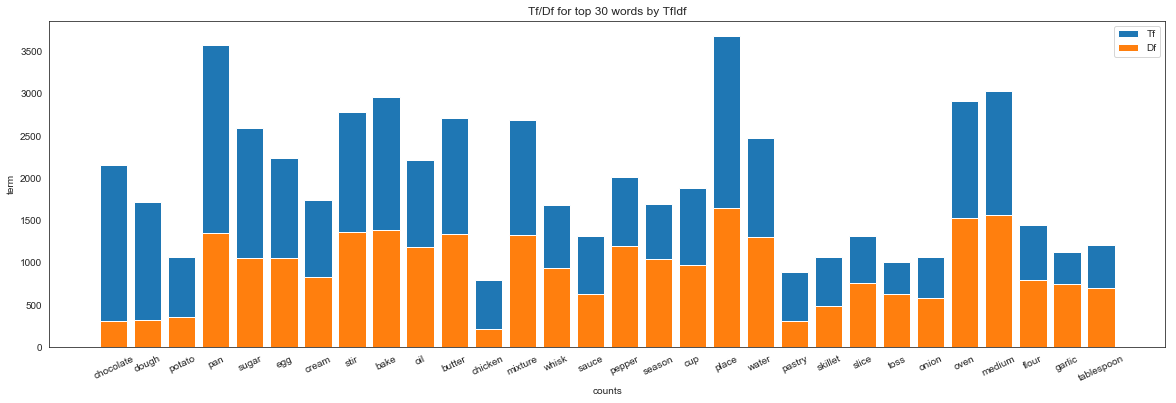

In [7]:
terms = keyword_df['keyword'][:30]
tf = keyword_df['term_frequency'][:30]
df = keyword_df['document_frequency'][:30]

sns.set_style('white')

graph = plt.figure(figsize=(20,6))
graph.add_axes()
subplot = graph.add_subplot(111)
subplot.bar(terms,tf)
subplot.bar(terms,df)
subplot.set(
    title = 'Tf/Df for top 30 words by TfIdf',
    xlabel = 'counts',
    ylabel = 'term'
           )
subplot.legend(['Tf','Df'])
subplot.set_xticklabels(terms,rotation=25)
graph.show()